# Approaching a 3D Hot Jupiter Model With PLUTO
## Summary of Key Attributes of the Setup
### PLUTO
Version 4.3 of PLUTO is used in the C code.

### definitions.h
- MHD physics module
- Spherical geometry
- Rotating frame
- 3 day rotation period
- Radial coordinate extends to 1.6 times the radius of Jupiter
- Unit length: $L = 1.6*6.9911\times10^9 [cm] / 1.2 = 9.321466666\times10^9$
- Unit velocity: $V = 1.0e5 [cm/s]$
- Unit density: $1.0e-9$
- $div(B) = 0$ control: constrained transport with UCT_HLL EMF average
- Background field splitting: enabled
- Resistivity: enabled, super time-stepping

Consequently, unit time is $T = L / V = 93214.6666667 [s] = 1.07887345679 [days]$

### pluto.ini
**Grid and solver**
- X1-grid (radius): 2 coordinate patches, each with with uniform spacing
    - 0.01 to 1.0 has 20 elements
    - 1.0 to 1.2 has 10 elements
- X2-grid (elevation): 1 coordinate patch with 36 elements, extending $\pm80^\circ$ above the equator
- X3-grid (azimuth): 1 coordinate patch with 80 elements, wrapping around the globe completely
- CFL = 0.25 with max var 1.1
- hllc solver
- van Leer limiter

**Boundary conditions**
- X1-beg: axisymmetric
- X1-end: userdef
- X2-beg: outflow
- X2-end: outflow
- X3-beg: periodic
- X3-end: periodic

**User parameters**
- ALPHA = 10.0
- VMAX = 1.0
    - Max value of the $V_{phi}$ profile
- EXP_DECAY = 10.0  
    - Time constant for the exponential $V_phi$ profile
- TRELAX = 8.403361344  
    - Relaxation time in code units
- BSURFACE = 5
    - Surface value of background magnetic field

### init.c
**Body force**
- The gravitational field is given by
$$
g = 
   \begin{cases} 
      -1/R^2           & \quad{\rm for} \quad R > 1 \\
      aR + bR^2 + cR^3 & \quad{\rm for} \quad R < 1 \\
   \end{cases}
$$
Additionally, the rotating frame weakens the effect of gravity in proportion to the cylindrical radius (about the axis of rotation) due to centrifugal force. PLUTO handles this internally for all dynamics, but the centrifugal force needs to be accounted for manually in initial and boundary conditions.

**Initial conditions**
- The density field is initialized to a state of hydrostatic equilibrium
- All velocities are initially 0
- Angular velocity of rotating frame is $$\Omega_z = \frac{L}{V T_r}=\frac{(1.6*6.9911\times10^9 [cm]) / 1.2}{10^5 [cm/s] \times3*34*3600 [s]}=0.357$$ in code units, where $L$ and $V$ are the unit length and velocity, respectively, and $T$ is the period of rotation. Note that we define $L$ as the planet radius, $R_p$, divided by the end coordinate of the radius grid ($1.2$) so that unit radius ($1.0$) corresponds to the gravitational field transition from the interior of the planet to the exterior, and maximum radius ($1.2$) corresponds to the edge of the atmosphere

**Boundary conditions**
- At the end of the radial coordinate, all velocities are 0
- At the end of the radial coordinate, density is set to $exp\bigg(\alpha\big((\frac{1}{R}-1) + \frac{1}{2}\Omega_z^2R^2sin^2(\theta)\big)\bigg)$ and pressure is set to $\rho/\alpha$ (isothermal). The second term in the exponential is to account for centrifugal force, and this also appears in the initial condition
- At the end of the radial coordinate, the radial component of the magnetic field is reflected

**Winds (body force along phi coordinate)**
- Winds can be enabled using an internal boundary condition, which forces a certain $v_{phi}$ profile in a portion of the fluid. Alternatively, winds can be imposed as a body force. The latter approach is preferred since it can be time-dependent in a sense by _relaxing_ to the desired profile, while the former generally has a discontinuous state at the boundary of the profile.
- Using the relaxation scheme, the force along the phi coordinate is as follows: $$F_{phi} = \frac{V_{profile} - V_{phi}}{\tau_{relax}}$$
    Where $V_{profile}$ is one of the time-independent profiles below, $V_{phi}$ is the current velocity along the phi coordinate, and $\tau = t [days] / T$. For example, a relaxation of 3 rotation periods corresponds to $\tau = 3\times3 / T = 3\times3 / 1.07887345679 = 8.342$ code units.
- Two wind profiles are available:
    - Exponential profile (`#define WINDS_EXP`): $$exp\big(10(R/R_p - 1)\big) sin(m\theta + b)$$
    - Quadratic profile (`#define WINDS_QUAD`): $$\bigg(\frac{R}{R_p}\bigg)^2sin(m\theta + b)$$
    Where $m$ and $b$ are constants used to make the profiles maximum at the equator, and $0$ at the ends of the elevation grid

**Magnetic field**
- Magnetic field splitting used, which means that a background curl-free magnetic field ($B0$) is specified, and the magnetic field recorded by PLUTO is the deviation from this background field ($B1$).
- Two background fields are available:
    - Dipole (`#define B_DIPOLE`): $$B0 = \frac{M}{r^3}\big(2cos(\theta)\hat{r} + sin(\theta)\hat{\theta}\big)$$
    - Weak uniform (`Define B_UNIFORM`): $$B0 = \frac{\sqrt{8\pi\times min(p)}}{1000} \hat{z}$$
    Where $M = \text{BSURFACE}\times max(R)^3 / (V \times \sqrt{4\pi P})$, where the last factor is for converting the field in Gauss to code units, and $min(p)$ is the minimum pressure in the domain.

**Resistivity**
- Given a conductivity in $[S/m]$ (SI), we can find a corresponding conductivity in c.g.s. units by multiplying by $c^2/10^{11}$, where $c$ is the speed of light in $[cm/s]$. For example, $\sigma_{SI}=1 [S/m] \rightarrow \sigma_{cgs}=8.988\times10^9 [s^{-1}]$.
- Resistivity is given by $$\eta = \frac{c^2}{4\pi\sigma_{cgs}}$$
- For example, a conductivity of $1 [S/m]$ corresponds to a resistivity of $7.95\times10^9 [cm^2/s]$
- To non-dimensionalize $\eta$, we divide by $L^2/T = LV$. For $L$ and $V$ defined previously, this means $L^2/T = 9.3214667\times10^{14}$
- Simplifying, we get: $$\eta_c = \frac{10^{11}}{4\pi\sigma_{SI}LV}$$ and for our particular choice of $L$ and $V$: $$\eta_{c,cgs}(\sigma_{SI}) = \frac{8.537\times10^{-6}}{\sigma_{SI}}$$ or $$\eta_{c,cgs}(\sigma_{cgs}) = \frac{7.673\times10^4}{\sigma_{cgs}}$$

# Analysis of Results

In [1]:
%config IPCompleter.greedy=True

import os
# from scripts.load_util 
# from scripts.field_util
# from scripts.calc_util
from scripts.vis_util import *

from __future__ import print_function

# Uncomment this to display plots in this notebook. Not recommended
# for large data sets (e.g. more than 10 frames).
# Note that all plots will be saved to the working directory anyway.
# %matplotlib inline

## Loading Data
Make sure ```path_to_script```, below, is set to the location where this script is running

Next, we may have a choice between different data sets to load. These have been enumerated above. To change the data set, change the value of `set_idx`, below to one of the other indices.

In [2]:
path_to_script = os.path.join(os.environ['PLUTO_DIR'], 'Work\\')
w_dir = os.path.join(path_to_script, "data")
print("Loading data from", w_dir)

data_dirs = [directory for directory in os.listdir(os.path.join(w_dir)) if "." not in directory]
print("Found data directories: ")
i = 0
for dir in data_dirs:
    print("\t{0}: {1}".format(i, dir))
    i = i + 1

Loading data from D:\PLUTO\Work\data
Found data directories: 
	0: 10t_centrifugal_exp_winds
	1: 10t_centrifugal_exp_winds_old
	2: 10t_centrifugal_no_winds
	3: 10t_centrifugal_no_winds_old
	4: 3t_centrifugal_no_winds
	5: 3t_centrifugal_no_winds_old
	6: 3t_with_centrifugal
	7: centrifugal_exp_winds_tau2p8
	8: centrifugal_exp_winds_tau5p6
	9: centrifugal_exp_winds_tau8p4
	10: centrifugal_exp_winds_tau8p4_old
	11: centrifugal_exp_winds_vr0_vtheta0
	12: centrifugal_no_winds
	13: centrifugal_no_winds_vr0_vtheta0
	14: disk_planet_no_rotation
	15: disk_planet_rotation
	16: mag_15t
	17: mag_30t
	18: mag_3t
	19: mag_dipole
	20: mag_dipole_15t
	21: mag_dipole_1t
	22: mag_dipole_1t_10G
	23: mag_dipole_30t
	24: mag_dipole_3t
	25: mag_dipole_current
	26: mag_dipole_current_old
	27: mag_dipole_no_bg_field
	28: mag_dipole_no_bg_field_small_t
	29: mag_dipole_reflective_tau2p78
	30: mag_dipole_small_t
	31: mag_new_density
	32: mag_uniform_b
	33: mag_uniform_b_high_res
	34: resistivity_1e-1Spm
	35: resis

In [3]:
set_idx = 39
wdir = os.path.join(w_dir, data_dirs[set_idx] + os.sep)
print("Using working directory", wdir)

Using working directory D:\PLUTO\Work\data\resistivity_profile\


Next, we use pyPLUTO to load the data in ```wdir``` into a ```pload``` object. ```dh[n]``` is the data handle for data.```n```.dbl.

In [4]:
dh = load_pluto_dataframes(wdir)

Reading Data file : D:\PLUTO\Work\data\resistivity_profile\data.0000.dbl
Reading Data file : D:\PLUTO\Work\data\resistivity_profile\data.0001.dbl
Reading Data file : D:\PLUTO\Work\data\resistivity_profile\data.0002.dbl
Reading Data file : D:\PLUTO\Work\data\resistivity_profile\data.0003.dbl
Reading Data file : D:\PLUTO\Work\data\resistivity_profile\data.0004.dbl
Reading Data file : D:\PLUTO\Work\data\resistivity_profile\data.0005.dbl
Reading Data file : D:\PLUTO\Work\data\resistivity_profile\data.0006.dbl
Reading Data file : D:\PLUTO\Work\data\resistivity_profile\data.0007.dbl
Reading Data file : D:\PLUTO\Work\data\resistivity_profile\data.0008.dbl
Reading Data file : D:\PLUTO\Work\data\resistivity_profile\data.0009.dbl
Reading Data file : D:\PLUTO\Work\data\resistivity_profile\data.0010.dbl
Reading Data file : D:\PLUTO\Work\data\resistivity_profile\data.0011.dbl
Reading Data file : D:\PLUTO\Work\data\resistivity_profile\data.0012.dbl
Reading Data file : D:\PLUTO\Work\data\resistivity_

In [5]:
load_unit_constants(wdir)
load_user_params(wdir)
pass

Attempting to load unit constants
Using unit constants:
	UNIT_DENSITY = 1e-09 [g/cm]
	UNIT_VELOCITY = 100000.0 [cm/s]
	UNIT_LENGTH = 9321466666.7 [cm]

Loading user params
User params:
	EXP_DECAY: 10.0
	BSURFACE: 5.0
	TRELAX: 2.780678
	ETA: 8.5e-05
	VMAX: 1.0
	ALPHA: 10.0


In [6]:
# TODO (tyler): find a more flexible way of doing this
for frame in dh:
    frame.Bx1 = get_physical_b_units(frame.Bx1)
    frame.Bx2 = get_physical_b_units(frame.Bx2)
    frame.Bx3 = get_physical_b_units(frame.Bx3)
print("Converted all magnetic field quantities from code units to cgs units")

Converted all magnetic field quantities from code units to cgs units


In [7]:
try:
    settings.B0 = MagField()
    settings.B0.load_field(dh[0], wdir)
    print("LOADED background magnetic field")
except Exception as e:
    print(e)
    print("No background magnetic field file to load")

LOADED background magnetic field


In [8]:
try:
    settings.eta = EtaField()
    settings.eta.load_field(dh[0], wdir)
    print("LOADED resistivity field")
except Exception as e:
    print(e)
    print("No resistivity field file to load")

LOADED resistivity field


## Image Settings

In [9]:
set_image_defaults() # One-time configuration of some matplotlib settings

# Vector Plots

## Analysis Parameters

In [10]:
# Plot a few specific frames. Note that -1 will plot all frames
frames = range(len(dh))
mgr = image_set_manager(wdir)

# Scale to these velocities for each frame
v_analyze = [0.1, 1.0]

# Scale to these magnetic fields for each frame
b_analyze = [5.0, 1e-2]

# Scale to these currents for each frame
j_analyze = [1.0]

## Velocities on an elevation slice

In [ ]:
mgr.clear_set()
for vmax in v_analyze:
    for idx in frames:
        plot_2d(dh, mgr, const_azimuth=True, data_idx=idx, field='v_r', arrows=True, v_min=-1*vmax, v_max=vmax)
    mgr.end_set()

In [ ]:
mgr.clear_set()
for vmax in v_analyze:
    for idx in frames:
        plot_2d(dh, mgr, const_azimuth=True, data_idx=idx, field='v_theta', arrows=True, v_min=-1*vmax, v_max=vmax)
    mgr.end_set()

## Zonal velocities at equator

In [ ]:
mgr.clear_set()
for vmax in v_analyze:
    for idx in frames:
        plot_2d(dh, mgr, const_elevation=True, theta=90, data_idx=idx, field='v_phi', arrows=True, v_min=-1*vmax, v_max=vmax)
    mgr.end_set()

# Currents

## Currents on an elevation slice

In [ ]:
mgr.clear_set()
for jmax in j_analyze:
    for idx in frames:
        plot_2d(dh, mgr, const_azimuth=True, data_idx=idx, field='j_r', arrows=True, v_min=-1*jmax, v_max=jmax)
    mgr.end_set()

In [ ]:
mgr.clear_set()
for jmax in j_analyze:
    for idx in frames:
        plot_2d(dh, mgr, const_azimuth=True, data_idx=idx, field='j_theta', arrows=True, v_min=-1*jmax, v_max=jmax)
    mgr.end_set()

## Zonal currents at equator

In [ ]:
mgr.clear_set()
for jmax in j_analyze:
    for idx in frames:
        plot_2d(dh, mgr, const_elevation=True, theta=45, data_idx=idx, field='j_phi', arrows=True, v_min=-1*jmax, v_max=jmax)
    mgr.end_set()

## Magnetic field on an elevation slice

In [ ]:
mgr.clear_set()
for bmax in b_analyze:
    # With background field
    for idx in frames:
        plot_2d(dh, mgr, const_azimuth=True, data_idx=idx, field='b_r', arrows=True, v_min=-1*bmax, v_max=bmax)
    mgr.end_set()
    
    # Without background field
    for idx in frames:
        plot_2d(dh, mgr, const_azimuth=True, data_idx=idx, field='b_r', arrows=True, bg_field=False, v_min=-1*bmax, v_max=bmax)
    mgr.end_set()

In [ ]:
mgr.clear_set()
for bmax in b_analyze:
    # With background field
    for idx in frames:
        plot_2d(dh, mgr, const_azimuth=True, data_idx=idx, field='b_theta', arrows=True, v_min=-1*bmax, v_max=bmax)
    mgr.end_set()
        
    # Without background field
    for idx in frames:
        plot_2d(dh, mgr, const_azimuth=True, data_idx=idx, field='b_theta', arrows=True, bg_field=False, v_min=-1*bmax, v_max=bmax)
    mgr.end_set()

## Zonal magnetic field at equator

In [ ]:
mgr.clear_set()
for bmax in b_analyze:            
    # Without background field
    for idx in frames:
        plot_2d(dh, mgr, const_elevation=True, theta=20, data_idx=idx, field='b_phi', arrows=True, bg_field=False, v_min=-1*bmax, v_max=bmax)
    mgr.end_set()

## Density

In [ ]:
mgr.clear_set()
for idx in frames:
    plot_2d(dh, mgr, const_azimuth=True, log=True, data_idx=idx, field='rho')
mgr.end_set()

## Resistivity

In [ ]:
# Eta is only dumped out once at the beginning of the code, so no need to do more than 1 plot
mgr.clear_set()
plot_2d(dh, mgr, const_azimuth=True, log=False, data_idx=0, field='eta_r')
mgr.end_set()

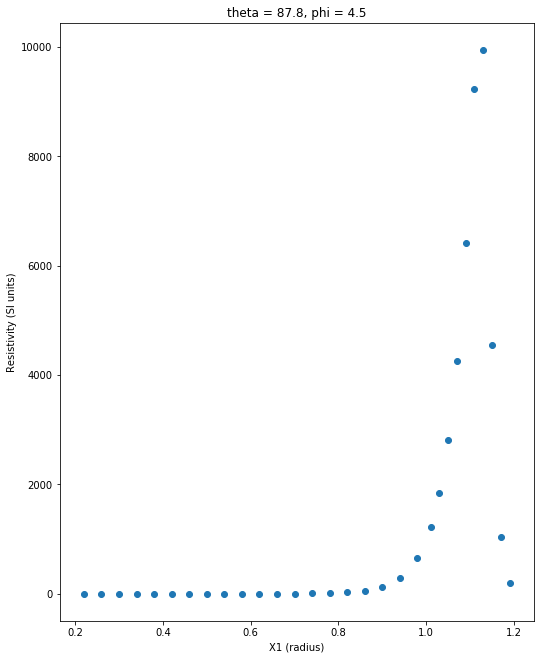

In [13]:
subplot_radius_vs_eta_2d(dh, 90, 0);
mgr.save_plt('eta_vs_rad_equator_profile')

# Other Quantities Of Interest

In [14]:
plot_extrema_over_time(dh, mgr, "v_phi")
plot_extrema_over_time(dh, mgr, mgr, "v_theta")
plot_extrema_over_time(dh, mgr, "v_r")
plot_extrema_over_time(dh, mgr, "b_r")
plot_extrema_over_time(dh, mgr, "b_theta")
plot_extrema_over_time(dh, mgr, "b_phi")
plot_extrema_over_time(dh[1:], mgr, "j_r")
plot_extrema_over_time(dh[1:], mgr, "j_theta")
plot_extrema_over_time(dh[1:], mgr, "j_phi")

Saved plot as v_phi_extrema_vs_t
field argument is invalid
Saved plot as v_r_extrema_vs_t
Saved plot as b_r_extrema_vs_t
Saved plot as b_theta_extrema_vs_t
Saved plot as b_phi_extrema_vs_t
Saved plot as j_r_extrema_vs_t
Saved plot as j_theta_extrema_vs_t
Saved plot as j_phi_extrema_vs_t


### Ohmic Heating Computation

In [ ]:
# Constant ETA value
try:
    compute_ohmic_heating(dh, mgr, eta_const=user_params['ETA'])
except:
    print("Could not find user parameter \"ETA\"")

In [ ]:
# ETA vector field
try:
    # TODO (tyler): I hate the unit conversion below!!! It is so easy for it to break
    eta_code_units = get_eta_code_units(eta_si_to_cgs(settings.eta))
    # TODO (tyler): need to start using astropy.units so that units are tracked internally
    # by all quantities...that way I don't need to worry about keeping them straight...
    compute_ohmic_heating(dh, mgr, eta_field=eta_code_units)
except:
    print("Could not find resistivity field object \"eta\"")

### Ohmic Heating Dumps From PLUTO

In [ ]:
plot_ohmic_heating_from_pluto(dh, mgr)

## Radial Density Profile
Here we will plot how the density varies with radius, when the elevation and azimuth are fixed.

### North Pole

In [ ]:
subplot_radius_vs_density_2d(dh, 0, 0, log=True, first_only=True);
save_plt('rho_vs_rad_north_pole_profile')

### Equator

In [ ]:
subplot_radius_vs_density_2d(dh, 90, 0, first_only=False);
save_plt('rho_vs_rad_equator_profile')

### South Pole

In [ ]:
subplot_radius_vs_density_2d(dh, 180, 0, first_only=False);
save_plt('rho_vs_rad_south_pole_profile')

## 3D Plots

### Constant Azimuth

In [ ]:
mgr.clear_set()
for vmax in v_analyze:
    for idx in frames:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        pltSphData3D(dh[idx], 'v_theta', ax, size=1000, phi=40, v_min=-1*vmax, v_max=vmax)
        pltSphData3D(dh[idx], 'v_theta', ax, size=1000, phi=79, v_min=-1*vmax, v_max=vmax)
        mgr.save_plt('3d_const_azimuth_vtheta' + "_vmax" + str(np.round(vmax, 2)) + "_f" + str(idx) + "_1000", track=(idx != -1))
        plt.close()
    mgr.end_set()

In [ ]:
mgr.clear_set()
for bmax in b_analyze:
    for idx in frames:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        pltSphData3D(dh[idx], 'b_theta', ax, size=1000, phi=40, v_min=-1*bmax, v_max=bmax)
        pltSphData3D(dh[idx], 'b_theta', ax, size=1000, phi=79, v_min=-1*bmax, v_max=bmax)
        mgr.save_plt('3d_const_azimuth_btheta' + "_max" + str(np.round(bmax, 2)) + "_f" + str(idx) + "_1000", track=(idx != -1))
        plt.close()
    mgr.end_set()

In [ ]:
mgr.clear_set()
for bmax in b_analyze:
    for idx in frames:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        pltSphData3D(dh[idx], 'b_r', ax, size=1000, phi=40, v_min=-1*bmax, v_max=bmax)
        pltSphData3D(dh[idx], 'b_r', ax, size=1000, phi=79, v_min=-1*bmax, v_max=bmax)
        mgr.save_plt('3d_const_azimuth_br' + "_max" + str(np.round(bmax, 2)) + "_f" + str(idx) + "_1000", track=(idx != -1))
        plt.close()
    mgr.end_set()

### Combined Plots

In [ ]:
mgr.clear_set()
for vmax in v_analyze:
    for idx in frames:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        pltSphData3D(dh[idx], 'v_phi', ax, size=1000, phi=10, v_min=-1*vmax, v_max=vmax)
        pltSphData3D(dh[idx], 'v_phi', ax, size=1000, phi=50, v_min=-1*vmax, v_max=vmax)
        pltSphData3D(dh[idx], 'v_phi', ax, size=1000, theta=0, v_min=-1*vmax, v_max=vmax)
        pltSphData3D(dh[idx], 'v_phi', ax, size=1000, theta=35, v_min=-1*vmax, v_max=vmax)
        pltSphData3D(dh[idx], 'v_phi', ax, size=1000, r=1, v_min=-1*vmax, v_max=vmax)
        mgr.save_plt('3d_azimuth_and_elevation_vphi' + "_vmax" + str(np.round(vmax, 2)) + "_f" + str(idx) + "_1000", track=(idx != -1))
        plt.close()
    mgr.end_set()

In [ ]:
mgr.clear_set()
for vmax in v_analyze:
    for idx in frames:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        pltSphData3D(dh[idx], 'v_theta', ax, size=1000, phi=10, v_min=-1*vmax, v_max=vmax)
        pltSphData3D(dh[idx], 'v_theta', ax, size=1000, phi=50, v_min=-1*vmax, v_max=vmax)
        pltSphData3D(dh[idx], 'v_theta', ax, size=1000, theta=0, v_min=-1*vmax, v_max=vmax)
        pltSphData3D(dh[idx], 'v_theta', ax, size=1000, theta=35, v_min=-1*vmax, v_max=vmax)
        pltSphData3D(dh[idx], 'v_theta', ax, size=1000, r=1, v_min=-1*vmax, v_max=vmax)
        mgr.save_plt('3d_azimuth_and_elevation_vtheta' + "_vmax" + str(np.round(vmax, 2)) + "_f" + str(idx) + "_1000", track=(idx != -1))
        plt.close()
    mgr.end_set()

In [ ]:
mgr.clear_set()
for vmax in v_analyze:
    for idx in frames:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        pltSphData3D(dh[idx], 'v_r', ax, size=1000, phi=10, v_min=-1*vmax, v_max=vmax)
        pltSphData3D(dh[idx], 'v_r', ax, size=1000, phi=50, v_min=-1*vmax, v_max=vmax)
        pltSphData3D(dh[idx], 'v_r', ax, size=1000, theta=0, v_min=-1*vmax, v_max=vmax)
        pltSphData3D(dh[idx], 'v_r', ax, size=1000, theta=35, v_min=-1*vmax, v_max=vmax)
        pltSphData3D(dh[idx], 'v_r', ax, size=1000, r=1, v_min=-1*vmax, v_max=vmax)
        mgr.save_plt('3d_azimuth_and_elevation_vr' + "_vmax" + str(np.round(vmax, 2)) + "_f" + str(idx) + "_1000", track=(idx != -1))
        plt.close()
    mgr.end_set()